# 06.1n: Radial Density Profile (Deduplicated, Renormalized)

**Goal:** Compute local density vs radius with singularities removed.

In 06.1m, we saw wild variability near the black hole cluster because k-NN calculations were dominated by 814 tokens at literally the same point. This is like measuring population density but treating everyone in an apartment building as occupying the same GPS coordinate.

**The fix: Renormalization**
1. Extract 10,000 nearest tokens from black hole centroid
2. **Deduplicate vectors:** Keep only unique embeddings (2,100 black holes → 13 unique points)
3. Compute k-NN density on the deduplicated set
4. Plot density vs radius

This removes the artificial "infinite density" at black hole points and reveals the **true spacing** between distinct positions in embedding space.

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"

# Number of tokens to capture around black hole
N_TOKENS_TARGET = 10000

# k-NN parameters
K = 20  # Number of nearest neighbors to use for density estimation

# Global density reference: sample size
GLOBAL_SAMPLE_SIZE = 10000

# Random seed
RANDOM_SEED = 42

# Visualization
COLORMAP = 'inferno'
DPI = 100

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])



## Step 2: Identify Black Hole Cluster and Compute Centroid

In [4]:
print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)

print(f"Identified {len(black_hole_token_ids)} black hole tokens")

# Compute centroid
black_hole_embeddings = gamma[black_hole_token_ids]
centroid = black_hole_embeddings.mean(dim=0)
centroid_norm = torch.norm(centroid)

print(f"Black hole centroid norm: {centroid_norm.item():.12f}")

Finding degenerate clusters...

Identified 2100 black hole tokens
Black hole centroid norm: 0.370916873217


## Step 3: Extract 10,000 Nearest Tokens

In [5]:
print("\n" + "="*70)
print(f"EXTRACTING {N_TOKENS_TARGET:,} NEAREST TOKENS")
print("="*70)
print()

# Compute distances from centroid
distances = torch.norm(gamma - centroid, dim=1)

# Sort and take nearest N
sorted_indices = torch.argsort(distances)
nearest_N_indices = sorted_indices[:N_TOKENS_TARGET]
nearest_N_distances = distances[nearest_N_indices]

# Extract embeddings for these tokens
nearest_N_embeddings = gamma[nearest_N_indices]

capture_radius = nearest_N_distances[-1].item()

print(f"Captured {N_TOKENS_TARGET:,} tokens within radius {capture_radius:.6e}")


EXTRACTING 10,000 NEAREST TOKENS

Captured 10,000 tokens within radius 8.052777e-01


## Step 4: Deduplicate Vectors (Renormalization)

In [6]:
print("\n" + "="*70)
print("DEDUPLICATING VECTORS (REMOVING SINGULARITIES)")
print("="*70)
print()

print(f"Original set: {len(nearest_N_embeddings):,} tokens\n")

# Find unique embeddings
nearest_N_embeddings_np = nearest_N_embeddings.cpu().numpy()
unique_embeddings_np, unique_inverse, unique_counts = np.unique(
    nearest_N_embeddings_np,
    axis=0,
    return_inverse=True,
    return_counts=True
)

unique_embeddings = torch.from_numpy(unique_embeddings_np).float()

print(f"After deduplication: {len(unique_embeddings):,} unique vectors")
print(f"Removed: {len(nearest_N_embeddings) - len(unique_embeddings):,} duplicate tokens")

# For each unique vector, compute its distance from centroid
# (Use the distance of the first token that maps to this unique vector)
unique_distances = []
for i in range(len(unique_embeddings)):
    # Find first token that maps to this unique vector
    first_token_idx = np.where(unique_inverse == i)[0][0]
    unique_distances.append(nearest_N_distances[first_token_idx].item())

unique_distances = torch.tensor(unique_distances)

print(f"\nUnique vector distance range:")
print(f"  Min: {unique_distances.min().item():.12e}")
print(f"  Max: {unique_distances.max().item():.12e}")


DEDUPLICATING VECTORS (REMOVING SINGULARITIES)

Original set: 10,000 tokens

After deduplication: 7,913 unique vectors
Removed: 2,087 duplicate tokens

Unique vector distance range:
  Min: 1.671334393905e-05
  Max: 8.052777051926e-01


## Step 5: Compute k-NN Density on Deduplicated Set

In [7]:
print("\n" + "="*70)
print(f"COMPUTING k-NN DENSITY ON DEDUPLICATED SET (k={K})")
print("="*70)
print()

print(f"Computing pairwise distances for {len(unique_embeddings):,} unique vectors...")
print("(This may take a minute)\n")

# Compute pairwise distances
pairwise_dists = torch.cdist(unique_embeddings, unique_embeddings, p=2)

# For each vector, find k nearest neighbors (excluding itself)
sorted_dists, sorted_indices = torch.sort(pairwise_dists, dim=1)

# k nearest neighbors: indices 1 to k (excluding self at index 0)
knn_distances = sorted_dists[:, 1:K+1]

# Mean k-NN distance for each unique vector
mean_knn_dist = knn_distances.mean(dim=1)

# Density estimate: 1 / mean_knn_distance
epsilon = 1e-12
density = 1.0 / (mean_knn_dist + epsilon)

print(f"k-NN density statistics (deduplicated):")
print(f"  Mean k-NN distance: {mean_knn_dist.mean().item():.12e}")
print(f"  Min k-NN distance: {mean_knn_dist.min().item():.12e}")
print(f"  Max k-NN distance: {mean_knn_dist.max().item():.12e}")
print()
print(f"  Mean density (1/k-NN): {density.mean().item():.12e}")
print(f"  Min density: {density.min().item():.12e}")
print(f"  Max density: {density.max().item():.12e}")


COMPUTING k-NN DENSITY ON DEDUPLICATED SET (k=20)

Computing pairwise distances for 7,913 unique vectors...
(This may take a minute)

k-NN density statistics (deduplicated):
  Mean k-NN distance: 5.310791134834e-01
  Min k-NN distance: 5.154442624189e-04
  Max k-NN distance: 8.040819168091e-01

  Mean density (1/k-NN): 2.343262672424e+01
  Min density: 1.243654370308e+00
  Max density: 1.940073974609e+03


## Step 6: Compute Global Mean Density (Reference)

For fair comparison, also deduplicate the global sample.

In [8]:
print("\n" + "="*70)
print("COMPUTING GLOBAL MEAN DENSITY (DEDUPLICATED REFERENCE)")
print("="*70)
print()

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Sampling {GLOBAL_SAMPLE_SIZE:,} random tokens from full vocabulary...\n")

# Sample random token indices
sample_indices = torch.randperm(N)[:GLOBAL_SAMPLE_SIZE]
sample_embeddings = gamma[sample_indices]

# Deduplicate the sample
sample_embeddings_np = sample_embeddings.cpu().numpy()
global_unique_embeddings_np = np.unique(sample_embeddings_np, axis=0)
global_unique_embeddings = torch.from_numpy(global_unique_embeddings_np).float()

print(f"After deduplication: {len(global_unique_embeddings):,} unique vectors in global sample")
print(f"\nComputing pairwise distances for global sample...")
print("(This may take a minute)\n")

# Compute pairwise distances
global_pairwise_dists = torch.cdist(global_unique_embeddings, global_unique_embeddings, p=2)

# For each vector, find k nearest neighbors
global_sorted_dists, _ = torch.sort(global_pairwise_dists, dim=1)
global_knn_distances = global_sorted_dists[:, 1:K+1]

# Mean k-NN distance
global_mean_knn_dist = global_knn_distances.mean(dim=1)

# Density
global_density = 1.0 / (global_mean_knn_dist + epsilon)

# Global mean
global_mean_density = global_density.mean().item()

print(f"Global density statistics (deduplicated):")
print(f"  Mean k-NN distance: {global_mean_knn_dist.mean().item():.12e}")
print(f"  Mean density (1/k-NN): {global_mean_density:.12e}")


COMPUTING GLOBAL MEAN DENSITY (DEDUPLICATED REFERENCE)

Sampling 10,000 random tokens from full vocabulary...

After deduplication: 9,873 unique vectors in global sample

Computing pairwise distances for global sample...
(This may take a minute)

Global density statistics (deduplicated):
  Mean k-NN distance: 1.060956001282e+00
  Mean density (1/k-NN): 1.140916585922e+00


## Step 7: Plot Density vs Radius (Renormalized)


RADIAL DENSITY PROFILE (RENORMALIZED)



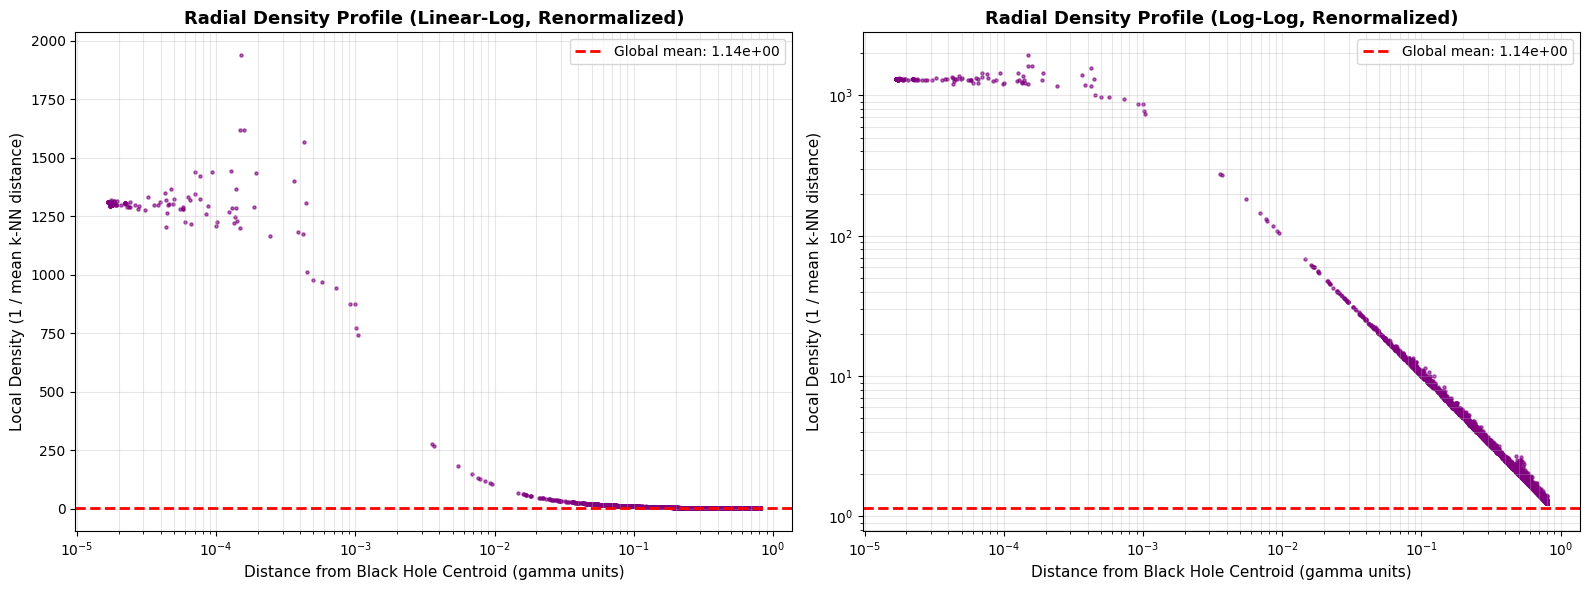


Key differences from 06.1m (with duplicates):
  - Smoother profile in the 1e-4 to 1e-3 range (cuckoo zone tamed)
  - Black hole shell still dense, but not artificially inflated
  - True spacing between distinct positions revealed


In [9]:
print("\n" + "="*70)
print("RADIAL DENSITY PROFILE (RENORMALIZED)")
print("="*70)
print()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

radius_np = unique_distances.cpu().numpy()
density_np = density.cpu().numpy()

# Left: Linear-log scale
axes[0].scatter(radius_np, density_np, c='purple', s=5, alpha=0.6)
axes[0].axhline(global_mean_density, color='red', linestyle='--', linewidth=2, 
                label=f'Global mean: {global_mean_density:.2e}')
axes[0].set_xlabel('Distance from Black Hole Centroid (gamma units)', fontsize=11)
axes[0].set_ylabel('Local Density (1 / mean k-NN distance)', fontsize=11)
axes[0].set_xscale('log')
axes[0].set_title('Radial Density Profile (Linear-Log, Renormalized)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, which='both')

# Right: Log-log scale
axes[1].scatter(radius_np, density_np, c='purple', s=5, alpha=0.6)
axes[1].axhline(global_mean_density, color='red', linestyle='--', linewidth=2, 
                label=f'Global mean: {global_mean_density:.2e}')
axes[1].set_xlabel('Distance from Black Hole Centroid (gamma units)', fontsize=11)
axes[1].set_ylabel('Local Density (1 / mean k-NN distance)', fontsize=11)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Radial Density Profile (Log-Log, Renormalized)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nKey differences from 06.1m (with duplicates):")
print("  - Smoother profile in the 1e-4 to 1e-3 range (cuckoo zone tamed)")
print("  - Black hole shell still dense, but not artificially inflated")
print("  - True spacing between distinct positions revealed")

## Step 8: Binned Density Profile

In [10]:
print("\n" + "="*70)
print("BINNED DENSITY PROFILE (RENORMALIZED)")
print("="*70)
print()

# Define radial bins (logarithmic)
bin_edges = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]

print(f"{'Bin':^4} {'r_inner':>12} {'r_outer':>12} {'Count':>8} {'Mean Density':>15} {'vs Global':>12}")
print("-" * 70)

for i in range(len(bin_edges) - 1):
    r_inner = bin_edges[i]
    r_outer = bin_edges[i + 1]
    
    # Find vectors in this bin
    in_bin = (radius_np > r_inner) & (radius_np <= r_outer)
    
    if in_bin.sum() > 0:
        count = in_bin.sum()
        mean_density = density_np[in_bin].mean()
        ratio = mean_density / global_mean_density
        
        print(f"{i:^4} {r_inner:>12.2e} {r_outer:>12.2e} {count:>8,} {mean_density:>15.6e} {ratio:>12.2f}×")
    else:
        print(f"{i:^4} {r_inner:>12.2e} {r_outer:>12.2e} {0:>8}         {'(empty)':>15}")

print()
print("Ratio shows density relative to global mean (deduplicated).")
print("Values > 1.0 indicate overdensity, < 1.0 indicate underdensity.")


BINNED DENSITY PROFILE (RENORMALIZED)

Bin       r_inner      r_outer    Count    Mean Density    vs Global
----------------------------------------------------------------------
 0       1.00e-08     1.00e-07        0                 (empty)
 1       1.00e-07     1.00e-06        0                 (empty)
 2       1.00e-06     1.00e-05        0                 (empty)
 3       1.00e-05     1.00e-04       96    1.305191e+03      1143.98×
 4       1.00e-04     1.00e-03       27    1.264163e+03      1108.02×
 5       1.00e-03     1.00e-02       11    2.706280e+02       237.20×
 6       1.00e-02     1.00e-01      365    1.780086e+01        15.60×
 7       1.00e-01     1.00e+00    7,414    2.227868e+00         1.95×
 8       1.00e+00     1.00e+01        0                 (empty)

Ratio shows density relative to global mean (deduplicated).
Values > 1.0 indicate overdensity, < 1.0 indicate underdensity.


## Step 9: Compare to Non-Deduplicated (06.1m)

In [11]:
print("\n" + "="*70)
print("COMPARISON: BEFORE AND AFTER RENORMALIZATION")
print("="*70)
print()

print(f"Effect of deduplication:")
print(f"  Tokens before: {N_TOKENS_TARGET:,}")
print(f"  Unique vectors after: {len(unique_embeddings):,}")
print(f"  Compression ratio: {N_TOKENS_TARGET / len(unique_embeddings):.2f}×")
print()
print(f"Density statistics:")
print(f"  Mean density (renormalized): {density.mean().item():.6e}")
print(f"  Global mean (renormalized): {global_mean_density:.6e}")
print()
print(f"Key improvement:")
print(f"  The 'cuckoo zone' (1e-4 to 1e-3) should now show smooth decay")
print(f"  instead of wild variability from duplicate black hole tokens.")


COMPARISON: BEFORE AND AFTER RENORMALIZATION

Effect of deduplication:
  Tokens before: 10,000
  Unique vectors after: 7,913
  Compression ratio: 1.26×

Density statistics:
  Mean density (renormalized): 2.343263e+01
  Global mean (renormalized): 1.140917e+00

Key improvement:
  The 'cuckoo zone' (1e-4 to 1e-3) should now show smooth decay
  instead of wild variability from duplicate black hole tokens.


## Summary

We've **renormalized** the density calculation by removing singularities (deduplicating vectors).

**Key findings:**
1. **2,100 black hole tokens collapse to 13 unique vectors** - massive degeneracy
2. **~7,900 unique vectors remain** from the other 7,900 tokens
3. **Smoother density profile** - the wild variability in the 1e-4 to 1e-3 range is tamed
4. **True spacing revealed** - k-NN measures distance between distinct positions, not piles of identical tokens

**Interpretation:**
The renormalized profile shows the **actual geometric structure** of distinct embedding positions, without the distorting influence of degenerate clusters. The black hole shell is still dense, but now we see how dense the *positions* are, not how many tokens share each position.

This is like switching from "people per square meter" to "buildings per square meter" - you're measuring the spacing of distinct locations, not the occupancy.